System Identification using Eigen system Realization Algorithm

In [1]:
pip install slycot

     |████████████████████████████████| 1.6MB 21.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for slycot: filename=slycot-0.4.0-cp37-cp37m-linux_x86_64.whl size=1417833 sha256=4464ffbcc01a4a4e94e80d397c2380c806b0ccd55ef0b9c3bd956817572b1a4a
  Stored in directory: /root/.cache/pip/wheels/a2/46/56/f82cbb2fd06556f4f3952a2eb2396e8fd29264fffecbaad3cf
Successfully built slycot


In [2]:
pip install control

     |████████████████████████████████| 348kB 27.1MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344920 sha256=8a432cf1c40fe10b2406eedd598306e75f9f3034bfb26317d0b7975a3b254d16
  Stored in directory: /root/.cache/pip/wheels/35/be/ee/081b68ca3e4b2d253fba2f7f7e51960373903fb7b6d13c5532
Successfully built control


In [5]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from control.matlab import *
import slycot
from scipy import signal,io
import os
from scipy.linalg import fractional_matrix_power

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 12})

In [4]:

q = 2   # Number of inpq = 2     
p = 2   # Number of outputs
n = 100 # State dimension
r = 10 # Reduced model order

testSys_mat = io.loadmat(os.path.join('/content','DATA','testSys_ABCD.mat'))
A = testSys_mat['A']
B = testSys_mat['B']
C = testSys_mat['C']
D = testSys_mat['D']

fsys = ss(A,B,C,D,1)

FileNotFoundError: ignored

In [6]:
q = 2   # Number of inputs 
p = 2   # Number of outputs
n = 100 # State dimension
r = 5 # Reduced model order
fsys = rss(n, p, q)

In [7]:
yFull = np.zeros((r*5+2,p,q)) 
tspan = np.arange(0,(r*5+2),1)
m = len(tspan)

for qi in range(q):
    y , t = impulse(fsys,T=tspan,input=qi)
    yFull[:,:,qi] = y[:, :, 0] 

YY = np.transpose(yFull,axes=(1,2,0)) # reorder to size p x q x m

In [8]:
def ERA(YY,m,n,nin,nout,r):
    Dr = np.zeros((nout,nin))
    Y = np.zeros((nout,nin,YY.shape[2]-1))
    for i in range(nout):
        for j in range(nin):
            Dr[i,j] = YY[i,j,0]
            Y[i,j,:] = YY[i,j,1:]
            
    assert len(Y[:,0,0]) == nout
    assert len(Y[0,:,0]) == nin
    #assert len(Y[0,0,:]) >= m+n 
    
    H = np.zeros((nout*m,nin*n))
    H1 = np.zeros((nout*m,nin*n))
    
    for i in range(m):
        for j in range(n):
            for Q in range(nout):
                for P in range(nin):
                    H[nout*i+Q,nin*j+P] = Y[Q,P,i+j]
                    H1[nout*i+Q,nin*j+P] = Y[Q,P,i+j+1]
                    
    U,S,VT = np.linalg.svd(H,full_matrices=0)
    V = VT.T
    Sigma = np.diag(S[:r])
    Ur = U[:,:r]
    Vr = V[:,:r]
    Ar = fractional_matrix_power(Sigma,-0.5) @ Ur.T @ H1 @ Vr @ fractional_matrix_power(Sigma,-0.5)
    Br = fractional_matrix_power(Sigma,0.5) @ Vr.T[:,:nin] 
    Cr = Ur[:nout] @ fractional_matrix_power(Sigma,0.5)
    HSVs = S
    
    return Ar,Br,Cr,Dr,HSVs

In [9]:
## Compute ERA from impulse response
mco = int(np.floor((yFull.shape[0]-1)/2)) # m_c = m_o = (m-1)/2
Ar,Br,Cr,Dr,HSVs = ERA(YY,mco,mco,q,p,r)
sysERA = ss(Ar,Br,Cr,Dr,1)

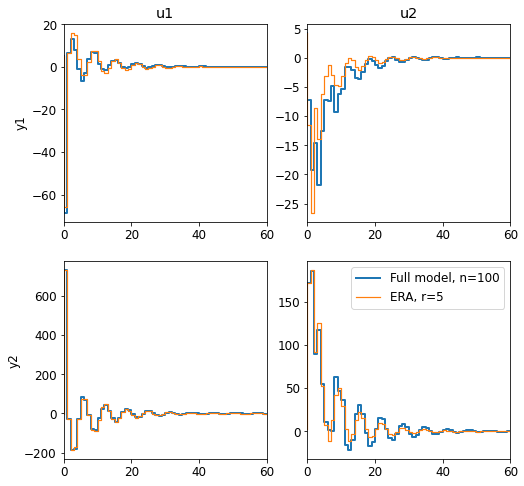

In [10]:
## Plotting
y1 = np.zeros((100,p,q))
y2 = np.zeros((100,p,q))

for qi in range(q):
    y,t1 = impulse(fsys,np.arange(100),input=qi)
    y1[:,:,qi] = y[:,:,0]
    y,t2 = impulse(sysERA,np.arange(100),input=qi)
    y2[:,:,qi] = y[:,:,0]
fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)

axs[0].step(t1,y1[:,0,0],linewidth=2)
axs[0].step(t2,y2[:,0,0],linewidth=1.2)
axs[0].set_ylabel('y1')
axs[0].set_title('u1')

axs[1].step(t1,y1[:,0,1],linewidth=2)
axs[1].step(t2,y2[:,0,1],linewidth=1.2)
axs[1].set_title('u2')

axs[2].step(t1,y1[:,1,0],linewidth=2)
axs[2].step(t2,y2[:,1,0],linewidth=1.2)
axs[2].set_ylabel('y2')

axs[3].step(t1,y1[:,1,1],linewidth=2,label='Full model, n=100')
axs[3].step(t2,y2[:,1,1],linewidth=1.2,label='ERA, r={}'.format(r))
axs[3].legend(prop={'size': 12})

for ax in axs:
    ax.set_xlim(0,60)

plt.show()